## JPEG

### Intro

L'objectif de ce projet est de réimplémenter entièrement l'algorithme JPEG. Qu'est-ce que JPEG ? JPEG, pour Joint Photographic Experts Group, est un algorithme de compression d'image avec perte. C'est-à-dire qu'après compression de l'image, une fois décompressée, on aura une perte de qualité car l'information qui nous permettait d'avoir une image en très haute définition a été jetée. Pourquoi jeter de l'information ? Dans le cas de la compression d'image, il n'est pas toujours utile de garder absolument toute l'information. En jetant une partie de l'information, la taille de l'image peut fortement diminuer.
 
A partir de maintenant, nous allons décrire le fonctionnement de l'algorithmes de compression et de décompression JPEG.
 
Il faut savoir qu'une image, ce n'est rien d'autre qu'un tableau de pixels (3 dimensions). Une cellule de ce tableau est de l'information sur un pixel.

Pour ce projet, nous avons besoin des librairies suivantes:

In [258]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.transform import resize
from scipy.fftpack import dct, idct
import cv2

L'image sur laquelle l'algorithme est testé est la suivante (en couleur et en niveaux de gris).
Le format choisi est '.tiff' afin de conserver un maximum d'information.

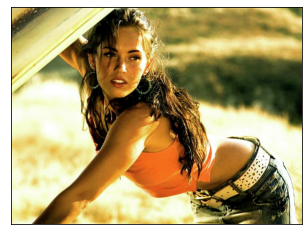

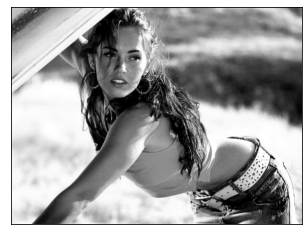

In [262]:
img_rgb = Image.open('./test.tiff')
img_gray = img_rgb.convert('L')
img_arr_rgb = np.array(img_rgb)
img_arr_gray = np.array(img_gray)

plt.rcParams["figure.figsize"] = [8,4]
plt.imshow(img_arr_rgb)
plt.xticks([])
plt.yticks([])
plt.show()
plt.imshow(img_arr_gray, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

# From RGB to YUV

En RGB, l'image (en couleur) est representee a l'aide d'une matrice en 3 dimensions (m, n, 3): m lignes, n colonnes et 3 canaux (1 rouge, 1 vert et 1 bleu).

YUV est un moyen de representer les informations contenues dans les images couleurs d'une facon differente. Y correspond a l'image en niveaux de gris (luminance). U et V contiennent des informations sur les couleurs de l'image (chrominance).

In [263]:
# from RGB to YUV

def to_yuv(img):
    return cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2YUV)

def to_rgb(img):
    return cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_YUV2RGB)

Comme on peut le voir, on converti l'image en YUV puis en la reconverti en RGB. On retrouve bien l'image de depart.

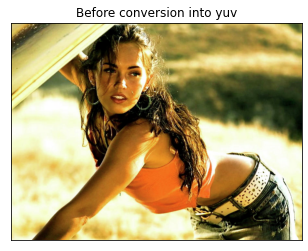

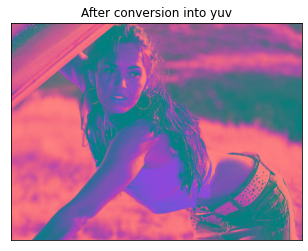

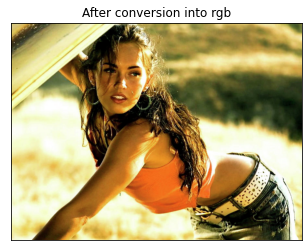

In [265]:
# TEST de la conversion
plt.rcParams["figure.figsize"] = [8,4]
plt.imshow(img_arr_rgb)
plt.title('Before conversion into yuv')
plt.xticks([])
plt.yticks([])
plt.show()
img_yuv = to_yuv(img_arr_rgb)
plt.imshow(img_yuv)
plt.title('After conversion into yuv')
plt.xticks([])
plt.yticks([])
plt.show()
img_rgb = to_rgb(img_yuv)
plt.imshow(img_rgb)
plt.title('After conversion into rgb')
plt.xticks([])
plt.yticks([])
plt.show()

### Transform the image into 8x8 blocks

La premiere étape de l'algorithme de compression JPEG, consiste en un découpage de l'image à compresser en blocks de 8x8. Dans le cas où la taille (ligne/colonne) de l'image n'est pas un multiple de 8, on applique du padding sur l'image. Dans notre cas, le padding symétrique est le plus efficace (on duplique les lignes et colonnes par symétrie)

In [266]:
def one_neg(block):
    for arr in block:
        for elm in arr:
            if elm < 0:
                return True
    return False

def get_next_8(nbr):
    '''
    Get next multiple of 8
    '''
    if nbr % 8 == 0:
        return nbr
    r = nbr // 8
    return (r + 1) * 8

def zeros_padding(img):
    '''
    Padd the image with 0
    '''
    shape = img.shape

    # nbr of columns/rows to add
    diff_rows = get_next_8(shape[0]) - shape[0]
    diff_cols = get_next_8(shape[1]) - shape[1]

    if diff_cols != 0:
        zeros_cols = np.zeros((shape[0], diff_cols))
        img = np.concatenate((img, zeros_cols), axis=1)

    if diff_rows != 0:
        zeros_rows = np.zeros((diff_rows, shape[1] + diff_cols))
        img = np.concatenate((img, zeros_rows), axis=0)

    return img

def symmetrical_padding(img):
    '''
    Padd the image with symmetrical rows and columns
    -> avoid creating high frequencies
    '''
    shape = img.shape

    # nbr of column/rows to add
    diff_rows = get_next_8(shape[0]) - shape[0]
    diff_cols = get_next_8(shape[1]) - shape[1]


    if diff_cols != 0:
        sym_arr = np.flip(img[:, -diff_cols:], axis=1)
        img = np.concatenate((img, sym_arr), axis=1)

    if diff_rows != 0:
        sym_arr = np.flip(img[-diff_rows:, :], axis=0)
        img = np.concatenate((img, sym_arr), axis=0)

    return img

def img_to_blocks(img, padding='zeros'):
    '''
    Get all the blocks (8x8)
    padding: 'zeros'/'symmetrical'
    '''
    if padding == 'zeros':
        img = zeros_padding(img)
    elif padding == 'symmetrical':
        img = symmetrical_padding(img)
    else:
        print("ERROR unknown padding")

    shape = img.shape

    n_rows = shape[0] // 8
    n_cols = shape[1] // 8
    res = np.empty((n_rows, n_cols, 8, 8))

    for i in range(n_rows):
        for j in range(n_cols):
            row_min, row_max = i * 8, (i + 1) * 8
            col_min, col_max = j * 8, (j + 1) * 8
            res[i, j, :, :] = img[row_min:row_max, col_min:col_max]

    return res

def blocks_to_img(blocks, mode='rgb'):
    '''
    Convert matrix from blocks representation into image representation
    '''
    shape = blocks.shape
    l = []
    res = np.empty((shape[0] * 8, shape[1] * 8))
    for i in range(shape[0]):
        for j in range(shape[1]):
            row_min, row_max = i * 8, (i + 1) * 8
            col_min, col_max = j * 8, (j + 1) * 8
            if one_neg(blocks[i, j]):
                l.append((i, j))
            res[row_min:row_max, col_min:col_max] = blocks[i, j]
    
    #if mode != 'yuv':
    #    return np.clip(res.astype(int), 0, 255)
    #else:
    return res.astype(int), l

Résultats après le padding symétrique:

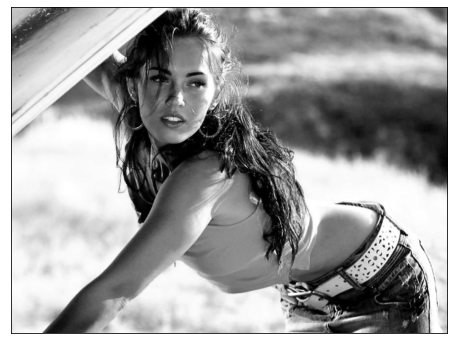

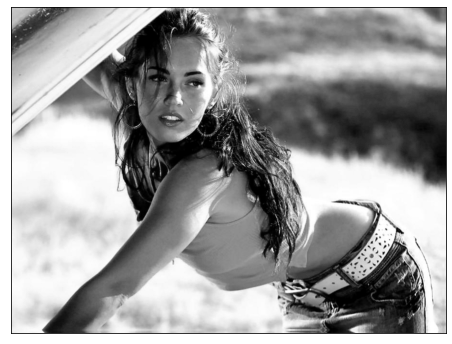

In [268]:
# img rgb
plt.rcParams["figure.figsize"] = [12,6]

plt.imshow(img_arr_gray, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()
blocks = img_to_blocks(img_arr_gray, padding='symmetrical')
res, _ = blocks_to_img(blocks)
plt.imshow(res, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

Ici on teste de le decoupage par block et le padding. On retrouve bien l'image de depart avec du padding.

In [269]:
blocks = img_to_blocks(img_arr_gray, padding='symmetrical')
tmp, _ = blocks_to_img(blocks)

img = symmetrical_padding(img_arr_gray)
assert True == np.all(tmp==img)

### DCT

La deuxieme étape de la compression JPEG consiste en l'application de la transformée en cosinus discret (DCT) sur chaque block de 8x8. Pour la décompression l'opération inverse (iDCT) est appliquée.

L'intérêt de la DCT est de représenter l'image dans espace différent. La plus basse fréquence représentant le block correspond au coefficient en haut à gauche dans la matrice 8x8. Tandis que la plus haute fréquence du block est le coefficient en bas a droite de la matrice.

Dans notre cas, on calcule la DCT sur chaque block - 128, afin de mettre la moyenne du block à 0.

Pour des questions de perfomances, l'utilisation du module scipy pour le calcule de la DCT/IDCT à été choisi.
Les formules de la DCT sont expliquées dans ce papier: http://m.reznik.org/papers/SPIE07_MPEG-C_IDCT.pdf

In [271]:
## COMPRESSION

def block_dct(block):
    block -= 128
    return dct(dct(block, axis=0, norm='ortho' ), axis=1, norm='ortho')

def img_dct(img_blocks):
    shape = img_blocks.shape
    for i in range(shape[0]):
        for j in range(shape[1]):
            img_blocks[i, j, :, :] = block_dct(img_blocks[i, j])
    return np.round(img_blocks)

def block_idct(block):
    res = idct(idct(block, axis=0 , norm='ortho'), axis=1 , norm='ortho') + 128
    return np.where(res < 0, 0, res)

def img_idct(img_blocks):
    shape = img_blocks.shape
    for i in range(shape[0]):
        for j in range(shape[1]):
            b = block_idct(img_blocks[i, j])
            img_blocks[i, j, :, :] = block_idct(img_blocks[i, j])
    return img_blocks


Ici on teste la DCT et l'inverse DCT. Au cours de cette étape, il y a très peu de perte d'information car l'opération de DCT est réversible. Les seuls pertes d'informations sont dues aux arrondis lors de l'inverse DCT.

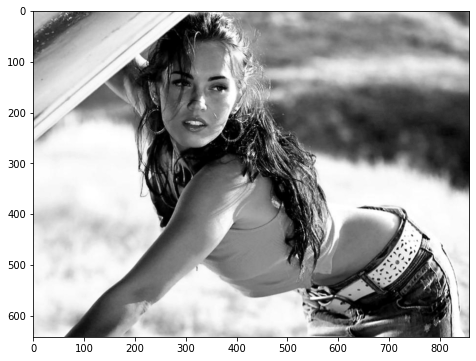

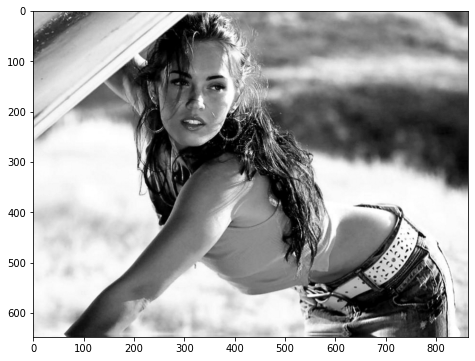

In [272]:
plt.rcParams["figure.figsize"] = [12,6]

plt.imshow(img_arr_gray, cmap='gray')
plt.show()
blocks = img_to_blocks(img_arr_gray, padding='symmetrical')
dct_blocks = img_dct(blocks)
idct_blocks = img_idct(dct_blocks)

res, l = blocks_to_img(idct_blocks)
plt.imshow(res, cmap='gray')
plt.show()

### Quantification step

La troisième étape de l'algorithme de JPEG est une étape de quantification. Chaque block (8x8) de l'image est quantifié par une matrice de quantification particulière.

L'opération de quantification consiste en une division terme à terme de chaque éléments d'une matrice.

L'opération inverse est le produit de Hadamar. Cette operation est utilisée lors de la décompression.

C'est à cette étape que l'on perd beaucoup d'information. En effet, l'objectif de la quantification est d'annuler les termes correspondant aux hautes et moyennes fréquences de chaque block après DCT.

Par ailleurs, dans le cas de la représentation YUV, les matrices U et V utilisent une matrice de quantification particulière qui annule beaucoup plus de termes.

De plus, c'est à cette étape qu'il est possible de définir le taux de compression (ici représenté par le parametre q).

In [273]:
## COMPRESSION

def quantification(block, luminance, q):
    '''
    Quantification step on 1 8x8 block
    luminance: Wether it's for luminance or chrominance image
    '''

    if luminance:
        q_luminance = np.array([
            [16, 11, 10, 16, 24, 40, 51, 61],
            [12, 12, 14, 19, 26, 58, 60, 55],
            [14, 13, 16, 24, 40, 57, 69, 56],
            [14, 17, 22, 29, 51, 87, 80, 62],
            [18, 22, 37, 56, 68, 109, 103, 77],
            [24, 35, 55, 64, 81, 104, 113, 92],
            [49, 64, 78, 87, 103, 121, 120, 101],
            [72, 92, 95, 98, 112, 100, 103, 99]
        ], dtype='float')
        
        if q < 50:
            alpha = 5000 / q
        else:
            alpha = 200  - 2 * q
        q_luminance = (alpha * q_luminance + 50) / 100
        return np.round(block / q_luminance), q_luminance

    else:
        q_chrominance = np.array([
            [17, 18, 24, 47, 99, 99, 99, 99],
            [18, 21, 26, 66, 99, 99, 99, 99],
            [24, 26, 56, 99, 99, 99, 99, 99],
            [47, 66, 99, 99, 99, 99, 99, 99],
            [99, 99, 99, 99, 99, 99, 99, 99],
            [99, 99, 99, 99, 99, 99, 99, 99],
            [99, 99, 99, 99, 99, 99, 99, 99],
            [99, 99, 99, 99, 99, 99, 99, 99]
        ])
        
        return np.round(block / q_chrominance), q_chrominance
    
def compute_quantification(img_blocks, luminance, q):
    '''
    Compute quantification on each block
    luminance: weather its a luminance block or not
    q: compression quality
    '''
    shape = img_blocks.shape
    
    for i in range(shape[0]):
        for j in range(shape[1]):
            img_blocks[i, j, :, :], q_mat = quantification(img_blocks[i, j], luminance, q)
    return img_blocks, q_mat

## DECOMPRESSION

def dequantification(block, quantification_mat):
    '''
    Quantification step on 1 8x8 block
    luminance: Wether it's for luminance or chrominance image
    '''
    return np.einsum('ij,ij->ij', block, quantification_mat)

def compute_dequantification(img_blocks, quantification_mat):
    '''
    Dequantification step on each block
    '''
    shape = img_blocks.shape
    
    for i in range(shape[0]):
        for j in range(shape[1]):
            img_blocks[i, j, :, :] = dequantification(img_blocks[i, j], quantification_mat)
    return img_blocks.astype(int)

Ici on teste notre les trois premières étapes de JPEG avec différent coefficient q de compression. On remarque que plus le coefficient q baisse plus la compression est importante (plus on perd de l'information).

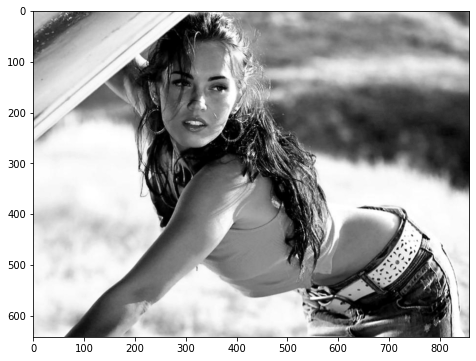

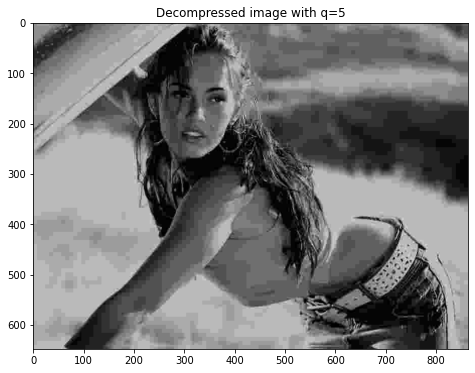

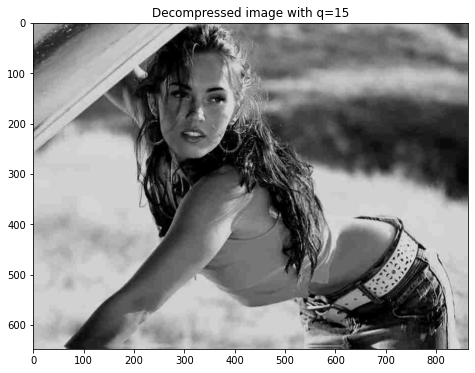

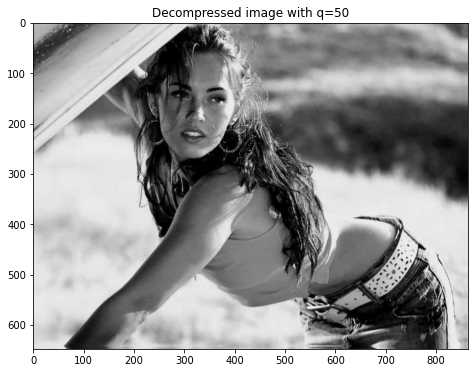

In [274]:
plt.rcParams["figure.figsize"] = [12,6]

plt.imshow(img_arr_gray, cmap='gray')
plt.show()
blocks = img_to_blocks(img_arr_gray.copy(), padding='symmetrical')
dct_blocks = img_dct(blocks)

q_blocks_1, q_mat_1 = compute_quantification(dct_blocks.copy(), luminance=True, q=5)
q_blocks_2, q_mat_2 = compute_quantification(dct_blocks.copy(), luminance=True, q=15)
q_blocks_3, q_mat_3 = compute_quantification(dct_blocks.copy(), luminance=True, q=50)


deq_blocks_1 = compute_dequantification(q_blocks_1, q_mat_1)
deq_blocks_2 = compute_dequantification(q_blocks_2, q_mat_2)
deq_blocks_3 = compute_dequantification(q_blocks_3, q_mat_3)

idct_blocks_1 = img_idct(deq_blocks_1)
idct_blocks_2 = img_idct(deq_blocks_2)
idct_blocks_3 = img_idct(deq_blocks_3)

img_1, _ = blocks_to_img(idct_blocks_1)
img_2, _ = blocks_to_img(idct_blocks_2)
img_3, _ = blocks_to_img(idct_blocks_3)


plt.imshow(img_1, cmap='gray')
plt.title('Decompressed image with q=5')
plt.show()

plt.imshow(img_2, cmap='gray')
plt.title('Decompressed image with q=15')
plt.show()

plt.imshow(img_3, cmap='gray')
plt.title('Decompressed image with q=50')
plt.show()

### Zigzag linearisation

La quatrième étape de JPEG est la linéarisation zigzag. L'objectif est de linéariser chaque block de 8x8 à l'aide de l'algorithme zigzag. Ce choix de linéarisation est dû à la repartition des frequences dans chaque block de 8x8 apres DCT. La linéarisation zigzag est donc appropriée puisqu'elle positionne une grande partie des fréquences annulées par quantification à la fin, nous évitant de les encoder.

In [275]:
def reverse_zigzag(mat):
    '''
    Reverse Zigzag iteration over matrix 'mat' to count nb of zeros
    '''
    shape = mat.shape
    n_rows, n_cols = shape[0], shape[1]
    i, j, idx = n_rows - 1, n_cols - 1, 0

    # first element case
    if (mat[i, j] != 0):
        return idx
    idx += 1

    while (idx < n_rows * n_cols):
        # after diagonals cases
        if (j > 0):
            j -= 1
        else:
            i -= 1

        # diagonal from left to right
        while (j < n_cols and i >= 0):
            if (mat[i, j] != 0):
                return idx
            idx += 1
            i -= 1
            j += 1

        # rectify out of bound
        j -= 1
        i += 1

        # corner case
        if (i > 0):
            i -= 1
        else:
            j -= 1

        # diagonal from right to left
        while (j >= 0 and i < n_rows):
            if (mat[i, j] != 0):
                return idx
            idx += 1
            j -= 1
            i += 1

        # out of bound
        j += 1
        i -= 1
    
    return idx

def zigzag(mat):
    '''
    Zigzag iteration over matrix 'mat'
    '''
    # init
    i, j, idx = 0, 0, 0
    n_rows, n_cols = mat.shape

    nb_elm = reverse_zigzag(mat)
    nb_elm = n_rows * n_cols - nb_elm

    if (nb_elm == 0):
        return np.array([])
    res = np.zeros(nb_elm)

    # first element case
    res[idx] = mat[i][j]
    idx += 1

    while (idx < nb_elm):
        if (j < n_cols -1):
            j += 1
        else:
            i += 1

        # diagonal from right to left
        while (j >= 0 and i < n_rows):
            if (idx >= nb_elm):
                return res
            res[idx] = mat[i][j]
            idx += 1
            i += 1
            j -= 1

        # out of bound i and j
        j += 1
        i -= 1

        if (i < n_rows - 1):
            i += 1
        else:
            j += 1

        # diagonal from left to right
        while (i >= 0 and j < n_cols):
            if (idx >= nb_elm):
                return res
            res[idx] = mat[i][j]
            idx += 1
            i -= 1
            j += 1

        # out of bound i and j
        i += 1
        j -= 1

    return res

def apply_zigzag(mat_blocks):
    '''
    Apply zigzag on each block
    '''
    shape = mat_blocks.shape
    res = []
    
    for i in range(shape[0]):
        for j in range(shape[1]):
            res.append(zigzag(mat_blocks[i, j]))
    return res

def zigzag_to_matrix(arr):
    '''
    From array into zigzag matrix
    '''
    res = np.zeros((8, 8))

    # init
    i, j, idx = 0, 0, 0
    n_rows, n_cols = res.shape

    if len(arr) == 0:
        return res
    # first element case
    res[i][j] = arr[idx]
    idx += 1

    while (idx < len(arr)):
        if (j < n_cols -1):
            j += 1
        else:
            i += 1

        # diagonal from right to left
        while (j >= 0 and i < n_rows):
            if (idx >= len(arr)):
                return res
            res[i][j] = arr[idx]
            idx += 1
            i += 1
            j -= 1

        # out of bound i and j
        j += 1
        i -= 1

        if (i < n_rows - 1):
            i += 1
        else:
            j += 1

        # diagonal from left to right
        while (i >= 0 and j < n_cols):
            if (idx >= len(arr)):
                return res
            res[i][j] = arr[idx]
            idx += 1
            i -= 1
            j += 1

        # out of bound i and j
        i += 1
        j -= 1

    return res

def build_zigzag_blocks(compressed_data, img_shape):
    '''
    Build the (n, m, 8, 8) blocks matrix of the image
    compressed_data: data in compressed format (list of numpy array) for each block
    img_shape: shape (number of block)
    '''
    res = np.empty((img_shape[0], img_shape[1], 8, 8))
    for i in range(img_shape[0]):
        for j in range(img_shape[1]):
            block = compressed_data[i * img_shape[1] + j]
            res[i, j, :, :] = zigzag_to_matrix(block)
            
    return res

Ici on teste le fonctionnement de la linearisation zigzag pour la compression et ensuite l'operation inverse pour la decompresssion.

In [276]:
# TEST zigzag

img_blocks = img_to_blocks(img_arr_gray)
dct_blocks = img_dct(img_blocks)
mat, _ = compute_quantification(dct_blocks, luminance=True, q=75)
cp_data = apply_zigzag(mat)
shape = (img_blocks.shape[0], img_blocks.shape[1])
res = build_zigzag_blocks(cp_data, shape)
assert True == np.all(res == mat)

#### Jpeg Compression / Decompression

In [277]:
def undersampling(img, chrominance):
    '''
    chrominance: '4:2:2' / '4:2:0'
    '''
    # remove columns
    if chrominance == '4:2:2' or chrominance == '4:2:0':
        pos = np.arange(0, img.shape[1], 2)
        img = img[:, pos]
    # remove rows
    if chrominance == '4:2:0':
        pos = np.arange(0, img.shape[0], 2)
        img = img[pos, :]
    return symmetrical_padding(img)

def interpolation(img, output_shape):
    '''
    Interpolate image
    '''
    return resize(img, output_shape)

def get_nbv_cp(cp_data):
    '''
    Get the number of values in compressed data
    '''
    nb = 0
    for arr in cp_data:
        nb += len(arr)
    return nb

def get_nbv_img(img_arr):
    '''
    Get number of values in 2d image
    '''
    shape = img_arr.shape
    return shape[0] * shape[1]

In [278]:
def compress_img_arr(mat, q, luminance=True, chrominance='4:4:4'):
    '''
    Compress a 2 dimension image
    '''
    print("COMPRESSION")
    if luminance == False and (chrominance == '4:2:2' or chrominance == '4:2:0'):
        mat = undersampling(mat, chrominance)
    
    default_mat_shape = mat.shape
    print("1) Transform into blocks")
    # transform the input image into 8x8 blocks
    mat_blocks = img_to_blocks(mat, padding='symmetrical')
    blocks_shape = (mat_blocks.shape[0], mat_blocks.shape[1])
    
    print("2) Compute DCT")
    # compute the DCT on each block
    mat_dct = img_dct(mat_blocks)
    
    print("3) Quantification")
    # compute quantification step on each block
    mat_quant, q_mat = compute_quantification(mat_dct, luminance, q)
    
    print("4) Zigzag")
    # apply zigzag on each block
    compressed_mat = apply_zigzag(mat_quant)
    
    # compressed_mat: compression format of the matrix
    # q_mat: quantification matrix of the matrix
    # blocks_shape: number of blocks (number in rows and in columns)
    # default_mat_shape: default shape of the matrix to compress (after changing the shape into multiple of 8)
    return compressed_mat, q_mat, blocks_shape, default_mat_shape

def jpeg_compress(img, mode='rgb', chrominance='4:4:4', q=75):
    '''
    img: image to compress
    mode: image representation (rgb/yuv)
    chromonance: 4:4:4 / 4:2:2 / 4:2:0 
    q: quality indice for luminance quantification
    '''
    # gray format
    if mode == 'grey':
        img_default_shape = img.shape
        cp_data, qmat, blocks_shape, default_mat_shape = compress_img_arr(img, q, luminance=True, chrominance='4:4:4')
        return (cp_data), (qmat, qmat), (blocks_shape) , img_default_shape
    
    # yuv compression format
    if (mode == 'yuv'):
        # convert the image into yuv
        img_yuv = to_yuv(img)
        y = img_yuv[:, :, 0]
        u = img_yuv[:, :, 1]
        v = img_yuv[:, :, 2]

        img_default_shape = y.shape
        
        if chrominance == '4:2:2':
            pass
        elif chrominance == '4:2:0':
            pass
        
        # compress y / u / v
        cp_data_y, qmat_lum, blocks_shape_y, default_mat_shape_y = compress_img_arr(y.copy(), q, luminance=True, chrominance=chrominance)
        cp_data_u, qmat_chro, blocks_shape_uv, default_mat_shape_uv = compress_img_arr(u.copy(), q, luminance=False, chrominance=chrominance)
        cp_data_v, _, _, _ = compress_img_arr(v.copy(), q, luminance=False, chrominance=chrominance)
        
        return (cp_data_y, cp_data_u, cp_data_v), (qmat_lum, qmat_chro), (blocks_shape_y, blocks_shape_uv, blocks_shape_uv), img_default_shape
    # rgb compression format
    else:
        # get r / g / b
        r = img[:, :, 0]
        g = img[:, :, 1]
        b = img[:, :, 2]
                
        # compress r / g / b
        cp_data_r, qmat, blocks_shape, _ = compress_img_arr(r.copy(), q)
        cp_data_g, _, _, _ = compress_img_arr(g.copy(), q)
        cp_data_b, _, _, _ = compress_img_arr(b.copy(), q)
        
        return (cp_data_r, cp_data_g, cp_data_b), (qmat, qmat), (blocks_shape, blocks_shape, blocks_shape), r.shape

def decompress_img_arr(compressed_data, quantif_mat, blocks_shape, img_default_shape, chrominance='4:4:4', mode='rgb'):
    '''
    compressed_data: list of numpy array with compressed data for each block
    quantif_mat: quantification matricx used
    blocks_shape: number of blocks (rows and columns)
    default_shape: defautl matrix shape (before padding)
    chrominance: type of chrominance
    '''
    print("DECOMPRESSION")
    
    # from compressed data into blocks
    print("1) Reverse Zigzag")
    zigzag_blocks = build_zigzag_blocks(compressed_data, blocks_shape)
    
    # dequantification
    print("2) Dequantification")
    dequant_blocks = compute_dequantification(zigzag_blocks, quantif_mat)
    
    # reverse DCT
    print("3) Reverse DCT")
    idct_blocks = img_idct(dequant_blocks)
    
    # from blocks into image
    print("4) Transform into image")
    if mode == 'yuv':
        image, _ = blocks_to_img(idct_blocks, mode='yuv')
    else:
        image, _ = blocks_to_img(idct_blocks)
    
    # add columns
    if chrominance == '4:2:2':
        image = interpolation(image, (image.shape[0], image.shape[1] * 2))
        
    # add rows and columns
    elif chrominance == '4:2:0':
        image = interpolation(image, (image.shape[0] * 2, image.shape[1] * 2))
    
    rows, cols = img_default_shape
    return image[:rows, :cols]

def jpeg_decompress(cp_data, q_mats, blocks_shape, img_default_shape, mode='rgb', chrominance='4:4:4'):
    '''
    cp_data: tuple with all the compressed channels (y, u, v) or (r, g, b)
    quantif_mats: tuple with two qantification matrix (one for luminance and one for chrominance)
    blocks_shape: number of blocks in the matrix
    default_shape: default shape of the image
    '''
    # gray case
    if mode == 'grey':
        channel = decompress_img_arr(cp_data, q_mats[0], blocks_shape, img_default_shape, chrominance='4:4:4')
        return channel.astype('int')
    # other case (rgb / yuv)
    else:
        (f_channel_cp, s_channel_cp, t_channel_cp) = cp_data
        
        f_channel = decompress_img_arr(f_channel_cp, q_mats[0], blocks_shape[0], img_default_shape, chrominance, mode)
        s_channel = decompress_img_arr(s_channel_cp, q_mats[1], blocks_shape[1], img_default_shape, chrominance, mode)
        t_channel = decompress_img_arr(t_channel_cp, q_mats[1], blocks_shape[2], img_default_shape, chrominance, mode)

        if mode == 'yuv':
            return to_rgb(np.dstack((f_channel, s_channel, t_channel)))
        
        return np.dstack((f_channel, s_channel, t_channel))

### JPEG en mode niveaux de gris

Premier teste de l'algorithme de compression/décompression JPEG en niveaux de gris.

On remarque qu'avec un coefficient q=20, il est difficile pour un humain de voir la différence.

In [281]:
cp_data, qmats, blocks_shape, img_default_shapes = jpeg_compress(img_arr_gray, q=20, mode='grey')
restored_img = jpeg_decompress(cp_data, qmats, blocks_shape, img_default_shapes, mode='grey')

COMPRESSION
1) Transform into blocks
2) Compute DCT
3) Quantification
4) Zigzag
DECOMPRESSION
1) Reverse Zigzag
2) Dequantification
3) Reverse DCT
4) Transform into image


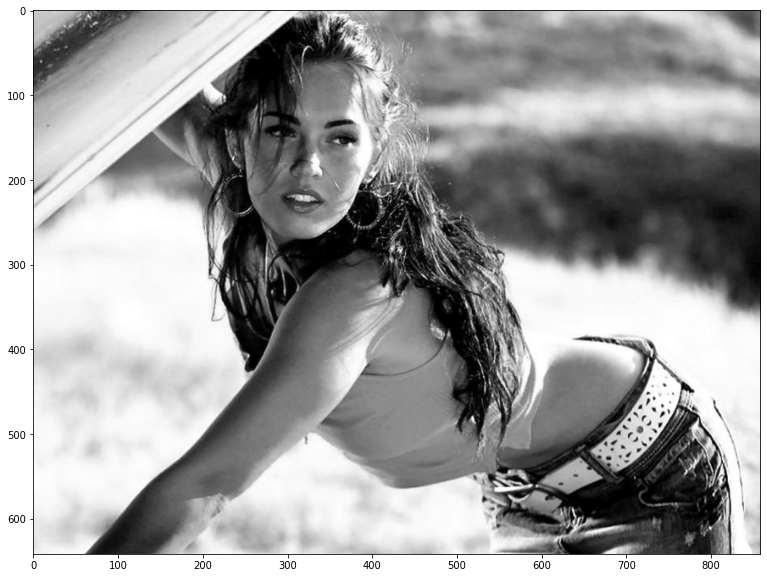

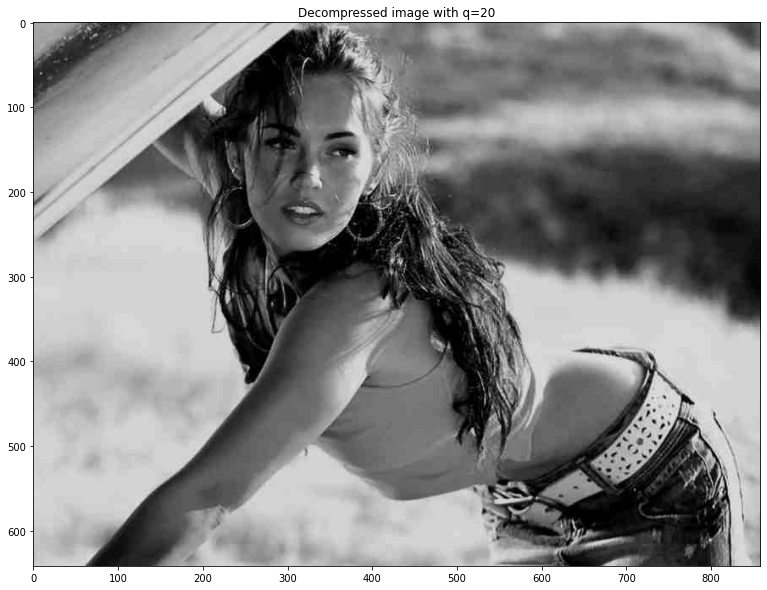

In [282]:
plt.rcParams["figure.figsize"] = [15,10]
plt.imshow(img_arr_gray, cmap='gray')
plt.show()
plt.imshow(restored_img, cmap='gray')
plt.title('Decompressed image with q=20')
plt.show()

On calcule donc le nombre de valeurs que l'on garde après compression. Après compression on garde 10 fois moins de valeurs.

In [285]:
default_img_vals = img_arr_gray.shape[0] * img_arr_gray.shape[1]

compressed_data_vals = get_nbv_cp(cp_data)

print("Nbr of values for the default image: {}".format(default_img_vals))
print("Nbr of values for the compressed data: {}".format(compressed_data_vals))
print("Compression rate: {}".format(np.round(default_img_vals / compressed_data_vals, 3)))

Nbr of values for the default image: 551478
Nbr of values for the compressed data: 55425
Compression rate: 9.95


### JPEG en mode RGB

Testons la compression en mode rgb avec q=15
On voit un peu plus la différence qu'avec q=20

In [286]:
cp_data, qmats, blocks_shape, img_default_shapes = jpeg_compress(img_arr_rgb, mode='rgb', chrominance='4:4:4', q=15)
restored_img = jpeg_decompress(cp_data, qmats, blocks_shape, img_default_shapes, mode='rgb', chrominance='4:4:4')

COMPRESSION
1) Transform into blocks
2) Compute DCT
3) Quantification
4) Zigzag
COMPRESSION
1) Transform into blocks
2) Compute DCT
3) Quantification
4) Zigzag
COMPRESSION
1) Transform into blocks
2) Compute DCT
3) Quantification
4) Zigzag
DECOMPRESSION
1) Reverse Zigzag
2) Dequantification
3) Reverse DCT
4) Transform into image
DECOMPRESSION
1) Reverse Zigzag
2) Dequantification
3) Reverse DCT
4) Transform into image
DECOMPRESSION
1) Reverse Zigzag
2) Dequantification
3) Reverse DCT
4) Transform into image


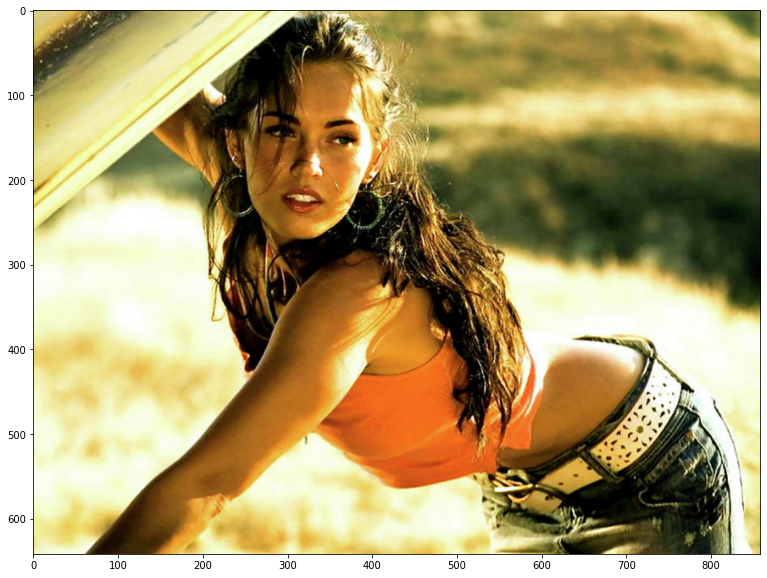

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


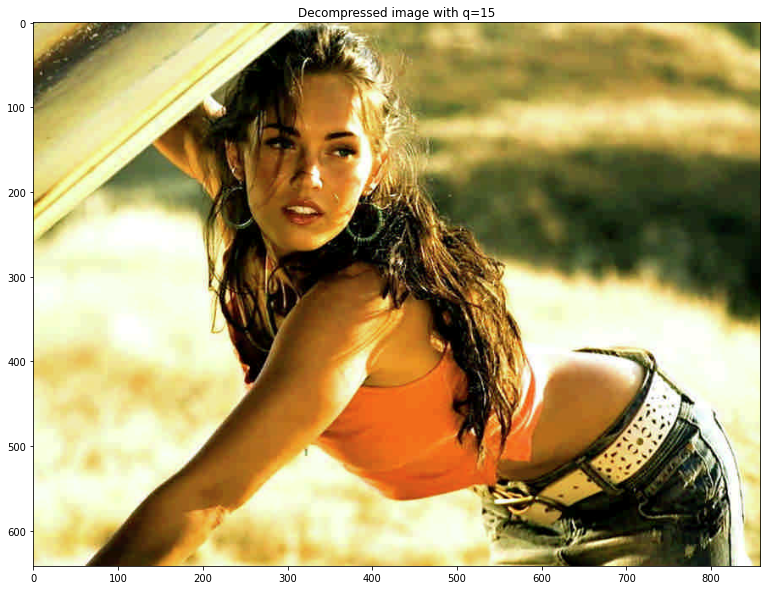

In [287]:
plt.rcParams["figure.figsize"] = [15,10]
plt.imshow(img_arr_rgb)
plt.show()
plt.imshow(restored_img)
plt.title('Decompressed image with q=15')
plt.show()

Après compression, on garde presque 12 fois moins de valeurs.

In [288]:
default_img_vals = img_arr_rgb.shape[0] * img_arr_rgb.shape[1] * img_arr_rgb.shape[2]

compressed_data_vals = get_nbv_cp(cp_data[0]) + get_nbv_cp(cp_data[1]) + get_nbv_cp(cp_data[2])

print("Nbr of values for the default image: {}".format(default_img_vals))
print("Nbr of values for the compressed data: {}".format(compressed_data_vals))
print("Compression rate: {}".format(np.round(default_img_vals / compressed_data_vals, 3)))

Nbr of values for the default image: 1654434
Nbr of values for the compressed data: 140289
Compression rate: 11.793


### JPEG en mode YUV  (chrominance 4:4:4)

Compression en mode YUV avec chrominance 4:4:4, c'est a dire sans supprimer de lignes ou de colonnes sur les cannaux U et V

In [289]:
cp_data, qmats, blocks_shape, img_default_shape = jpeg_compress(img_arr_rgb, mode='yuv', chrominance='4:4:4', q=95)
restored_img = jpeg_decompress(cp_data, qmats, blocks_shape, img_default_shapes, mode='yuv', chrominance='4:4:4')

COMPRESSION
1) Transform into blocks
2) Compute DCT
3) Quantification
4) Zigzag
COMPRESSION
1) Transform into blocks
2) Compute DCT
3) Quantification
4) Zigzag
COMPRESSION
1) Transform into blocks
2) Compute DCT
3) Quantification
4) Zigzag
DECOMPRESSION
1) Reverse Zigzag
2) Dequantification
3) Reverse DCT
4) Transform into image
DECOMPRESSION
1) Reverse Zigzag
2) Dequantification
3) Reverse DCT
4) Transform into image
DECOMPRESSION
1) Reverse Zigzag
2) Dequantification
3) Reverse DCT
4) Transform into image


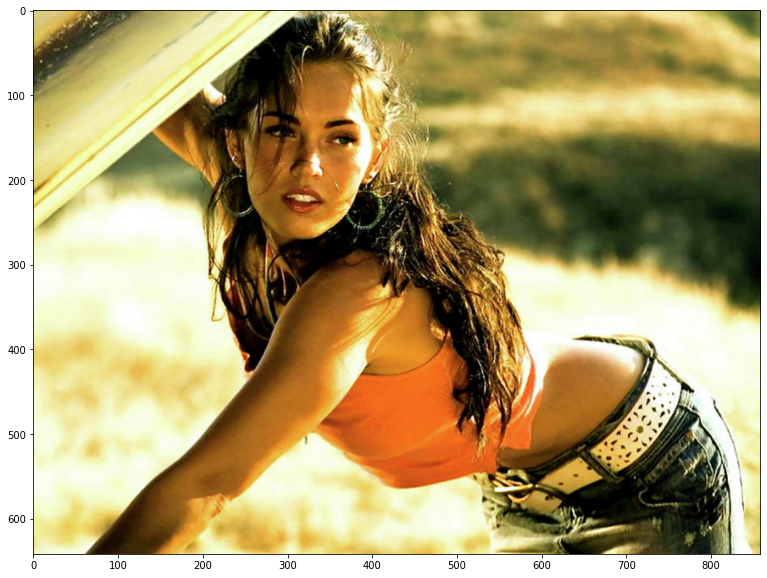

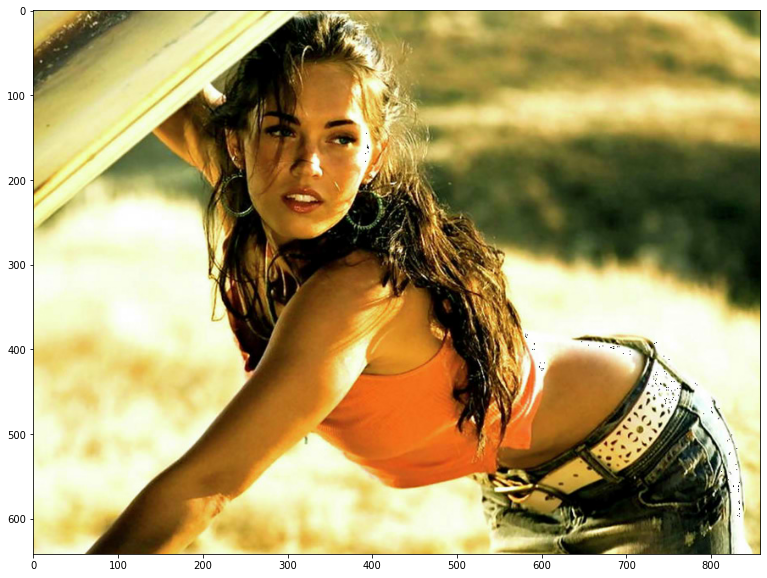

In [290]:
plt.rcParams["figure.figsize"] = [15,10]
plt.imshow(img_arr_rgb)
plt.show()
plt.imshow(restored_img)
plt.show()

In [291]:
default_img_vals = img_arr_rgb.shape[0] * img_arr_rgb.shape[1] * img_arr_rgb.shape[2]

compressed_data_vals = get_nbv_cp(cp_data[0]) + get_nbv_cp(cp_data[1]) + get_nbv_cp(cp_data[2])

print("Nbr of values for the default image: {}".format(default_img_vals))
print("Nbr of values for the compressed data: {}".format(compressed_data_vals))
print("Compression rate: {}".format(np.round(default_img_vals / compressed_data_vals, 3)))

Nbr of values for the default image: 1654434
Nbr of values for the compressed data: 277664
Compression rate: 5.958
